# Funciones de la máquina Boltzmann restringidas para la clasificación de dígitos

Para datos de imagen en escala de grises donde los valores de los píxeles se pueden interpretar como grados de negrura sobre un fondo blanco, como el reconocimiento de dígitos manuscritos, el modelo de máquina Boltzmann restringida de Bernoulli (: class: BernoulliRBM <sklearn.neural_network.BernoulliRBM>) puede realizar una extracción efectiva de características no lineales.

Con el fin de aprender buenas representaciones latentes de un pequeño conjunto de datos, generamos artificialmente más datos etiquetados perturbando los datos de entrenamiento con cambios lineales de 1 píxel en cada dirección.

Este ejemplo muestra cómo construir un canal de clasificación con un extractor de características de BernoulliRBM y una clase: LogisticRegression <sklearn.linear_model.LogisticRegression> clasificador. Los hiperparámetros de todo el modelo (tasa de aprendizaje, tamaño de capa oculto, regularización) se optimizaron mediante la búsqueda en cuadrícula, pero la búsqueda no se reproduce aquí debido a restricciones de tiempo de ejecución.

La regresión logística en valores de píxel en bruto se presenta para la comparación. El ejemplo muestra que las características extraídas por el BernoulliRBM ayudan a mejorar la precisión de la clasificación.

# Importamos la librerías

In [1]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD
# Adaptado: https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Definimos los métodos

In [2]:
# Configuracion inicial.
def nudge_dataset(X, Y):
    """
    Esto produce un conjunto de datos 5 veces más grande que el original, 
    al mover las imágenes 8x8 en X alrededor de 1px 
    a la izquierda, derecha, abajo, arriba.
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

# Cargamos los datos que usaremos

In [3]:
# Cargamos la data, de la libreria sklearn, los dataset de numeros de 8x8.
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Creamos el modelo

In [4]:
# Creacion del modelo.
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# Entrenamos el modelo

In [5]:
# Entrenamiento
# Hiper-parámetros. Estos se establecieron mediante validación 
# cruzada, utilizando un GridSearchCV. Aquí no estamos realizando 
# validación cruzada para ahorrar tiempo.
rbm.learning_rate = 0.06                    # Medida de aprendizaje.
rbm.n_iter = 20                             # Numero de iteraciones.

# Aumentar "components" tienden a dar un mejor rendimiento de predicción, 
# pero tambien incrementa el tiempo de ajuste.
rbm.n_components = 100
logistic.C = 6000

# Entrenamiento RBM-Logistic Pipeline.
rbm_features_classifier.fit(X_train, Y_train)

# Entrenando el clasificador de regresión logística directamente en el píxel.
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# Evaluacion
Y_pred = rbm_features_classifier.predict(X_test)
print("Regresión logística usando características RBM:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Regresión logística usando características de píxel en bruto:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.55s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.58s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.55s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.53s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.52s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.51s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.66s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.52s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.63s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.53s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.52s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.86s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.52s
[BernoulliRBM] Iteration 15, 

Podemos ver como avanza entre iteraciones y finalmente nos el "accurancy" o la exactitud con la que termina de entrenar.

# Graficamos

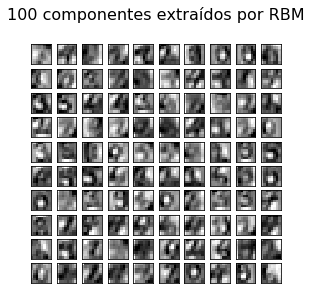

In [6]:
# Grafico
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 componentes extraídos por RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

Y el resultado final, imagenes generadas a partir de otras, se puede observar como de imagenes de 8x8 pixeles, se adapta la red para recrearlas.